### <center> <font size=4> <b>Informatica Musicale Project</b> </font></center>

# <center> <font size=10> <b>Speech Classification with MFCC and DTW</b> </font></center>
## <center>Guglielmo Camporese</center>

 
 <center>
 <b>Student ID</b>: 1153533<br>
<b>email</b>: guglielmocamporese@gmail.com <br>
<b>skype</b>: guglielmocamporese<br>
<b>linkedIn</b>: www.linkedin.com/in/guglielmocamporese </center>


<hr>

# The Idea of the Project
In this project I want to build an algorithm that can classify audio commands. The procedure can be understand from the schemes below:

### <center>Training Approach</center>
<img src="img/system2.png" width="800" height="800" />
<br> <br>
### <center>Dictionary Approach</center>
<img src="img/system3.png" width="800" height="800" />

In [1]:
#import the packages
import numpy as np #package for matrix calculus
from scipy.io import wavfile #package for read the wave files
import matplotlib.pyplot as plt #package for plotting
import scipy.fftpack as fftpack #package for the fft algorithm
from os import listdir #package for read an external files (used for read the audio files)
from os.path import isfile, join #package for read an external files (used for read the audio files)
from IPython.display import clear_output #package for clean the printed string in the jupyter notebook
import scipy.io as sio #package to save or load saved data

# Dataset

|<center>Class</center>|<center>Audio Example</center>|<center># of Examples</center>|
|-|-|
|<center>0</center>|<audio controls><source src="data/0_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>1</center>|<audio controls><source src="data/1_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>2</center>|<audio controls><source src="data/2_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>3</center>|<audio controls><source src="data/3_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>4</center>|<audio controls><source src="data/4_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>5</center>|<audio controls><source src="data/5_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>6</center>|<audio controls><source src="data/6_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>7</center>|<audio controls><source src="data/7_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>8</center>|<audio controls><source src="data/8_0.wav" type="audio/wav"></audio>|<center>10</center>|
|<center>9</center>|<audio controls><source src="data/9_0.wav" type="audio/wav"></audio>|<center>10</center>|

### Build the Dataset

In [2]:
#define a class that describe a single audio example in the dataset
class Audio:
    def __init__(self, audio_dir):
        self.dir_str = audio_dir 
        self.n_class = int(audio_dir[-7])
        self.fs, self.audio_samples = wavfile.read(audio_dir)
        
        if self.audio_samples.dtype == 'int16':
            self.audio_samples = self.audio_samples / 32767.
        if self.audio_samples.dtype == 'int32':
            self.audio_samples = self.audio_samples / 2147483647.
        if self.audio_samples.dtype == 'uint8':
            self.audio_samples = self.audio_samples / 255.
        
        self.ts = 1./self.fs #sample periodo of the audio file
        self.n_samples = len(self.audio_samples) #number of samples of the audio file
        
        #only mono audio data
        if self.audio_samples.shape != (self.n_samples,):
            self.audio_samples = self.audio_samples[:,0]
        
        self.duration = (self.n_samples-1)*self.ts #time duration in seconds of the audio file
        self.time_vect = np.array(range(self.n_samples))*self.ts
        
        self.frames = None
        self.energy_frames = None
        self.time_frames = None
        self.window_type = None
        self.window_len = None
        self.window_overlap = None
        self.STFT = None
        self.freq_frames = None
        self.MFCC = None

In [3]:
#build the dataset
folder_dir = 'data/'
dataset = [Audio(folder_dir+f) for f in listdir(folder_dir)[1:] if isfile(folder_dir+f)]

#display dataset info
N = len(dataset)
durations = [samples.duration for samples in dataset]
classes = [samples.n_class for samples in dataset]
samples_frequencies = [samples.fs for samples in dataset]
print 'Size of the Dataset :', N, 'examples'
print 'Min. Audio Duration :', min(durations), 's'
print 'Max. Audio Duration :', max(durations), 's'
print 'Avg. Audio Duration :', sum(durations) / len(durations), 's'
print 'Sample Frequency :', list(set(samples_frequencies)), 'Hz'
print 'Classes :', list(set(classes))
for c in range(len(list(set(classes)))):
    print '   Class', c, ':', classes.count(c), 'examples'

Size of the Dataset : 100 examples
Min. Audio Duration : 1.3853125 s
Max. Audio Duration : 2.36664583333 s
Avg. Audio Duration : 1.77656583333 s
Sample Frequency : [48000] Hz
Classes : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
   Class 0 : 10 examples
   Class 1 : 10 examples
   Class 2 : 10 examples
   Class 3 : 10 examples
   Class 4 : 10 examples
   Class 5 : 10 examples
   Class 6 : 10 examples
   Class 7 : 10 examples
   Class 8 : 10 examples
   Class 9 : 10 examples


<hr>

# Audio Processing

After the construction of the dataset I have to process the data in order to extract the features used for classification. Here I report the diagram of the processing to extract the <b>MFCC</b> audio features:


<img src="img/img_features_extraction2.png" width="1100px" height="1200px" />
#### Summary of the MFCC Features


|<center>#</center>| <center>Total MFCC </center>|
|-|-|
|<center>12</center>| <center>Cepstral Coefficients</center>|
|<center>1</center> | <center>Energy Coefficient</center>|

### Pre-Emphasis
#### IIR Filter Design

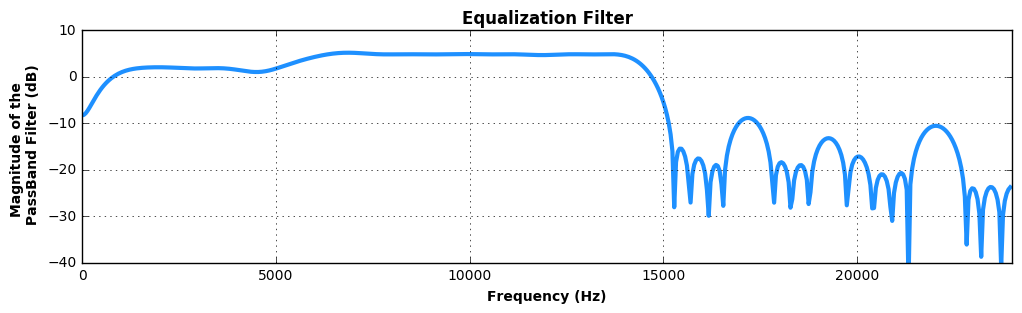

In [8]:
from scipy import signal
sample = dataset[0]

#IIR filter design
filter_order = 71

# High-pass filter
nyquist_rate = sample.fs / 2.
gain = np.array([0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0])*1.5
desired = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*gain
bands = np.linspace(0,1,20)*nyquist_rate
filter_coefs = signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

#plot the filter
freq, response = signal.freqz(filter_coefs)
th = np.zeros((len(freq),))
responde_abs_db = 10*np.log10(np.abs(response))
plt.figure(figsize=(12,3))
plt.title('Equalization Filter', fontweight='bold')
plt.plot(nyquist_rate*freq/(np.pi), responde_abs_db, linewidth=3, c='dodgerblue')
#plt.fill_between(nyquist_rate*freq/(np.pi), responde_abs_db, th, where= responde_abs_db>= th, 
#                 facecolor='darkblue', interpolate=True)
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Magnitude of the \n PassBand Filter (dB)', fontweight='bold')
plt.xlim(0, nyquist_rate)
plt.ylim(-40, 10)
plt.grid(True, which="both")
plt.show()

#### Example of filtering a signal

In [5]:
def pre_emphasis(x, filter_coefs, window_len=1024, overlap=0):
    #FRAMING
    n = len(x) #lenght of x
    
    s = window_len-overlap #stride
    n_window = int(np.ceil(1.*(n-window_len)/s + 1)) #number of windows

    x_fr = np.zeros((n_window, window_len)) #x windowed
    x_fr_fft = np.zeros((n_window, window_len)) #x windowed
    x_fr_filt = np.zeros((n_window, window_len)) #x windowed
    x_fr_filt_fft = np.zeros((n_window, window_len)) #x windowed
    time_fr = np.zeros((n_window, window_len)) #time frame
    
    #pre-emphasis
    ind1 = 0
    for i in range(n_window-1):
        ind2 = ind1 + window_len
        x_fr[i, :] = x[ind1:ind2]
        x_fr_fft[i, :] = np.absolute(np.fft.fft(x[ind1:ind2]))/window_len
        x_fr_filt[i, :] = signal.filtfilt(filter_coefs, [1], x[ind1:ind2])
        x_fr_filt_fft[i, :] = np.absolute(np.fft.fft(x_fr_filt[i,:]))/window_len
        time_fr[i, :] = np.arange(ind1, ind2)
        
        ind1 = ind1 + s

    #tail of the vector
    for j in range(n-ind1):
        x_fr[-1, j] = x[ind1+j] 

    return (x_fr, x_fr_fft, x_fr_filt, x_fr_filt_fft, time_fr)

In [6]:
sample = dataset[0]

#parameters
w_len = 1024
overlap = w_len/4
(x_fr, x_fr_fft, x_fr_filt, x_fr_filt_fft, time_fr) = pre_emphasis(sample.audio_samples, filter_coefs, 
                                                                   window_len=w_len, overlap=overlap)

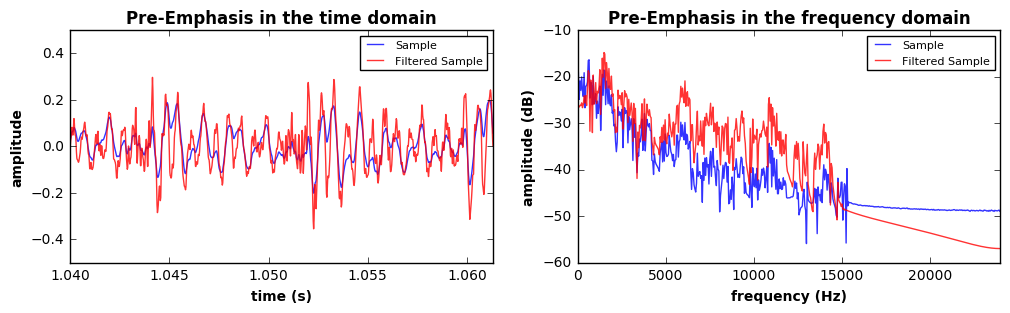

In [7]:
#plot
n_frame = 65
plt.figure(figsize=(12,3))
#plt.suptitle('Pre-Emphasis', fontweight='bold', size=20)

plt.subplot(1,2,1)
plt.title('Pre-Emphasis in the time domain', fontweight='bold')
plt.plot(time_fr[n_frame,:]*sample.ts, x_fr[n_frame,:], c='blue', alpha=0.8, label='Sample')
plt.plot(time_fr[n_frame,:]*sample.ts, x_fr_filt[n_frame,:], c='red', alpha=0.8, label='Filtered Sample')
plt.xlim(np.min(time_fr[n_frame,:]*sample.ts), np.max(time_fr[n_frame,:]*sample.ts))
plt.ylim(-0.5,0.5)
plt.xlabel('time (s)', fontweight='bold')
plt.ylabel('amplitude', fontweight='bold')
plt.legend(loc=1, prop={'size': 8})
                  
plt.subplot(1,2,2)
plt.title('Pre-Emphasis in the frequency domain', fontweight='bold')
plt.plot(np.linspace(0,sample.fs,1024), 10*np.log10(x_fr_fft[n_frame,:]), c='blue', alpha=0.8, label='Sample')
plt.plot(np.linspace(0,sample.fs,1024), 10*np.log10(x_fr_filt_fft[n_frame,:]), 
         c='red', alpha=0.8, label='Filtered Sample')
plt.xlim(0, sample.fs/2.)
plt.xlabel('frequency (Hz)', fontweight='bold')
plt.ylabel('amplitude (dB)', fontweight='bold')
plt.legend(loc=1, prop={'size': 8})

plt.show()

### Framing

In [9]:
def framing(x, filter_coefs, window_len=1024, window_type='hann', overlap=0):
    #FRAMING
    n = len(x) #lenght of x
    
    k = np.array(range(window_len,))
    if window_type=='hann':
        window = 0.5*(1 - np.cos( 2*np.pi*k /(window_len-1) ))
    if window_type=='hamming':
        window = 0.54 - 0.46*np.cos( 2*np.pi*k /(window_len-1) )
    if window_type=='rect':
        window = np.ones((window_len,))
    
    s = window_len-overlap #stride
    n_window = int(np.ceil(1.*(n-window_len)/s + 1)) #number of windows

    x_fr = np.zeros((n_window, window_len)) #x windowed
    x_fr_filt = np.zeros((n_window, window_len)) #x windowed
    time_fr = np.zeros((n_window, window_len)) #time frame
    

    #convolution
    ind1 = 0
    for i in range(n_window-1):
        ind2 = ind1 + window_len
        x_fr_filt[i, :] = signal.filtfilt(filter_coefs, [1], x[ind1:ind2])
        x_fr[i, :] = x_fr_filt[i,:]*window
        time_fr[i, :] = np.arange(ind1, ind2)
        ind1 = ind1 + s

    #tail of the vector
    for j in range(n-ind1):
        x_fr[-1, j] = x[ind1+j]*window[j]

    return (x_fr, time_fr, window)

#### Example of windowing

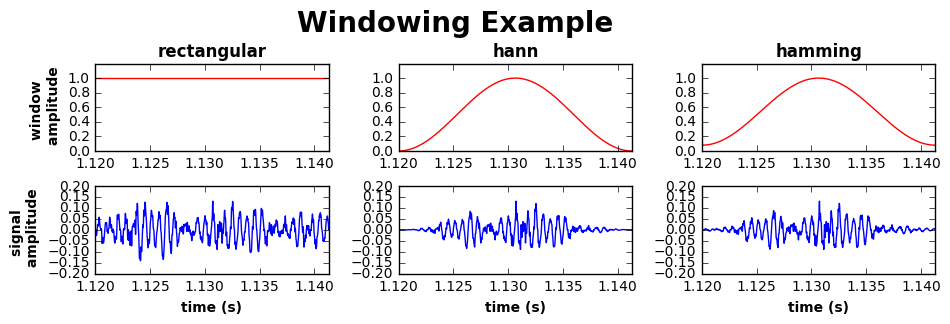

In [10]:
sample = dataset[0]

#parameters
w_len = 1024
w_type1 = 'rect'
w_type2 = 'hann'
w_type3 = 'hamming'
overlap = w_len/4
(frames1, time_fr, window1) = framing(sample.audio_samples, filter_coefs, window_len=w_len, window_type=w_type1, 
                                      overlap=overlap)
(frames2, time_fr, window2) = framing(sample.audio_samples, filter_coefs, window_len=w_len, window_type=w_type2, 
                                      overlap=overlap)
(frames3, time_fr, window3) = framing(sample.audio_samples, filter_coefs, window_len=w_len, window_type=w_type3, 
                                      overlap=overlap)

#plot
plt.figure(figsize=(12,3))
plt.suptitle('Windowing Example', fontweight='bold', size=20)
n_sample = 70

plt.subplot(2,3,1)
plt.title('rectangular', fontweight='bold')
plt.plot(time_fr[n_sample,:]*sample.ts, window1, c='r')
plt.xlim(np.min(time_fr[n_sample,:]*sample.ts), np.max(time_fr[n_sample,:]*sample.ts))
plt.ylabel('window \n amplitude', fontweight='bold')
plt.ylim(0,1.2)

plt.subplot(2,3,2)
plt.title('hann', fontweight='bold')
plt.plot(time_fr[n_sample,:]*sample.ts, window2, c='r')
plt.xlim(np.min(time_fr[n_sample,:]*sample.ts), np.max(time_fr[n_sample,:]*sample.ts))
plt.ylim(0,1.2)

plt.subplot(2,3,3)
plt.title('hamming', fontweight='bold')
plt.plot(time_fr[n_sample,:]*sample.ts, window3, c='r')
plt.xlim(np.min(time_fr[n_sample,:]*sample.ts), np.max(time_fr[n_sample,:]*sample.ts))
plt.ylim(0,1.2)

plt.subplot(2,3,4)
plt.plot(time_fr[n_sample,:]*sample.ts, frames1[n_sample,:])
plt.xlim(np.min(time_fr[n_sample,:]*sample.ts), np.max(time_fr[n_sample,:]*sample.ts))
plt.xlabel('time (s)', fontweight='bold')
plt.ylabel('signal \n amplitude', fontweight='bold')
plt.ylim(-0.2,0.2)

plt.subplot(2,3,5)
plt.plot(time_fr[n_sample,:]*sample.ts, frames2[n_sample,:])
plt.xlim(np.min(time_fr[n_sample,:]*sample.ts), np.max(time_fr[n_sample,:]*sample.ts))
plt.xlabel('time (s)', fontweight='bold')
plt.ylim(-0.2,0.2)

plt.subplot(2,3,6)
plt.plot(time_fr[n_sample,:]*sample.ts, frames3[n_sample,:])
plt.xlim(np.min(time_fr[n_sample,:]*sample.ts), np.max(time_fr[n_sample,:]*sample.ts))
plt.xlabel('time (s)', fontweight='bold')
plt.ylim(-0.2,0.2)

plt.subplots_adjust(left=0.2, bottom=0.1, wspace=0.3, top=0.8, hspace=0.4)

plt.show()

#### Windowing the dataset

In [11]:
#windowing the audio in the dataset
for sample in dataset:
    #parameters
    w_len = 1024
    w_type = 'hann'
    overlap = w_len/4
    
    (frames, time_fr, _) = framing(sample.audio_samples, filter_coefs, window_len=w_len, 
                                   window_type=w_type, overlap=overlap)
    sample.frames = frames
    sample.energy_frames = np.sum(frames**2, axis=1)
    sample.time_frames = time_fr*sample.ts
    sample.window_type = w_type
    sample.window_len = w_len
    sample.window_overlap = overlap
    sample.STFT = np.fft.fft(frames, axis=1)
    sample.freq_frames = np.linspace(0, sample.fs, w_len)

### Mel Filters Bank
#### Filters Design

In [12]:
#this function build the mel-filters bank from scratch
def getMelFiltersBank(f_min, f_max, freq_vect, fs, n_filters=26):
    #(f_min, f_max) = (300., dataset[0].fs/2.)
    m_min = 1125.*np.log(1+f_min/700.)
    m_max = 1125.*np.log(1+f_max/700.)
    w_len = len(freq_vect)
    m = np.linspace(m_min, m_max, n_filters+2)
    freq = 700.*(np.exp(m/1125.) - 1)
    f = np.floor((w_len)*freq/fs)

    filters = np.zeros((n_filters, w_len))
    for filter_n in range(1,n_filters+1):
        h = np.zeros((w_len,))
        for k in range(w_len):
            if 0 < f[filter_n-1]:
                h[k] = 0
        
            if f[filter_n-1] <= k and k <= f[filter_n]:
                h[k] = (k-f[filter_n-1])/(f[filter_n]-f[filter_n-1])
        
            if f[filter_n] <= k and k <= f[filter_n+1]:
                h[k] = (f[filter_n+1]-k)/(f[filter_n+1]-f[filter_n])
        
            if k > f[filter_n+1]:
                h[k] = 0
        filters[filter_n-1, :] = h
        
    return filters

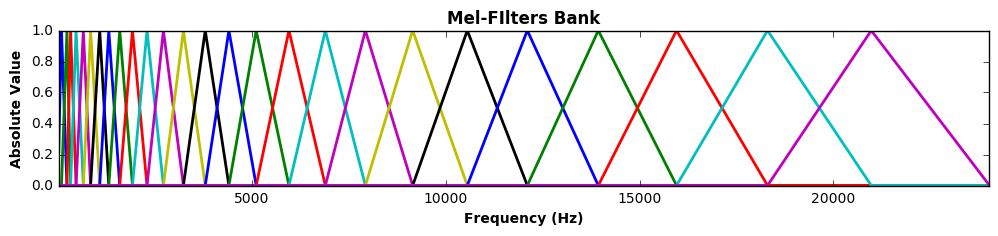

In [13]:
#build the mel-filters bank
n_filters = 26
fs = dataset[0].fs
f_min = 20
f_max = fs/2.
filters = getMelFiltersBank(f_min, f_max, dataset[0].freq_frames, fs, n_filters=n_filters)

#plot the mel-filters bank
plt.figure(figsize=(12,2))
plt.plot(dataset[0].freq_frames, filters.T, linewidth=2)
plt.xlim(f_min, f_max)
plt.title('Mel-FIlters Bank', fontweight='bold')
plt.xlabel('Frequency (Hz)', fontweight='bold')
plt.ylabel('Absolute Value', fontweight='bold')
plt.show()

In [14]:
#filter the audio in the dataset
for sample in dataset:
    x_fr = np.abs(sample.STFT)
    energy = np.zeros((x_fr.shape[0], n_filters))
    for n_frame in range(x_fr.shape[0]):
        frame = x_fr[n_frame, :]
        for n_filter in range(filters.shape[0]):
            filter = filters[n_filter, :]
            energy[n_frame, n_filter] = np.dot(frame, filter)**2
    energy_log = np.log(energy)
    #energy_log[energy_log==np.inf]=0
    #C = np.absolute(np.fft.ifft(energy_log, axis=1))
    C = fftpack.dct(energy_log, axis=1)
    sample.MFCC = C[:, 1:13]
    sample.MFCC = np.append(sample.MFCC, sample.energy_frames.reshape(len(sample.energy_frames), 1), axis=1)
    
    #delta
    delta = np.zeros((sample.MFCC.shape[0], sample.MFCC.shape[1]))
    delta[0, :] = sample.MFCC[0, :]
    delta[-1, :] = sample.MFCC[-1, :]
    for i in range(1, sample.MFCC.shape[0]-1):
        delta[i, :] = (sample.MFCC[i+1, :] - sample.MFCC[i-1, :]) / 2.
    
    #delta_delta
    delta_delta = np.zeros((sample.MFCC.shape[0], sample.MFCC.shape[1]))
    delta_delta[0, :] = sample.MFCC[0, :]
    delta_delta[1, :] = sample.MFCC[1, :]
    delta_delta[-1, :] = sample.MFCC[-1, :]
    delta_delta[-2, :] = sample.MFCC[-2, :]
    for i in range(2, sample.MFCC.shape[0]-2):
        delta_delta[i, :] = (sample.MFCC[i+1, :] - sample.MFCC[i-1, :] + 2*sample.MFCC[i+2, :] - 2*sample.MFCC[i-2, :])/ 10.
    
    #sample.MFCC = np.append(sample.MFCC, delta, axis=1)
    #sample.MFCC = np.append(sample.MFCC, delta_delta, axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


# Dynamic Time Warping
The objective of <b>DTW</b> is to compare two (time-dependent) sequences $X = (x_1, x_2, \dots , x_N)$ of length $N$ and $Y = (y_1, y_2, \dots, y_M)$ of length $M$. These sequences may be discrete signals ot, more generally (like in this case with the MFCCs), features sequences sampled at equidistant points in time. In the following I fix a feature space denoted by $\mathcal{F}$. Then $x_n$, $y_m \in \mathcal{F}$ for $n \in \{1,\dots, N\}$ and $m \in \{1,\dots,M\}$. To compare two different features $x$, $y \in \mathcal{F}$ one needs a local cost measure which is defined to be a function 
$$c: \mathcal{F} \times \mathcal{F} \rightarrow \mathbb{R}_{\geq 0}.$$
Typically, $c(x,y)$ is small (low cost) if $x$ and $y$ are similar to each other, and otherwise $c(x,y)$ is large (high cost). I collect the local costs $c(x_n, y_n)$ in the matrix $C \in \mathbb{R}^{N\times M}$ where $C(n,m) = c(x_n,y_m)$ and the goal is to find an alignment between $X$ and $Y$ having minimal overall cost.

<b> Definition :</b> warping path <br>
An $(N,M)$ warping path is a sequence $p=(p_1,\dots,p_L)$ with $p_l = (n_l,m_l) \in \{1,\dots,N\}\times \{1,\dots,M\}$ satisfyng:
1. <b>Boundary condition:</b> $p_1 = (1,1)$ and $p_L=(N,M)$
2. <b>Monotonicity condition:</b> $n_1 \leq n_2 \leq \dots \leq n_L$ and $m_1 \leq m_2 \leq \dots \leq m_L$
3. <b>Step size condition:</b> $p_{l+1}-p_l \in \{(1,0), (0,1), (1,1)\}$ for $l \in \{1, \dots, L-1\}$

After this definition I define the total cost of the warping path 
$$c_p(X,Y) = \sum_{l=1}^L c(x_{n_l}, y_{m_l})$$
where $c(x_{n_l}, y_{m_l}) = \|x_{n_l} - y_{m_l}\|_2$ for example and the optimal path
$$p^* = \underset{p}{\operatorname{argmin}}\big\{ c_p(X,Y) : p \text{ is an $(N,M)$ warping path}\big\}$$
and the DTW distance
$$DTW(X,Y) = c_{p^*}(X,Y) = \underset{p}{\operatorname{min}}\big\{ c_p(X,Y) : p \text{ is an $(N,M)$ warping path}\big\}.$$

To determine an optimal path $p^*$ I implement an $O(NM)$ algorithm that is based on <b>dynamic programming</b>. To this end I define $D(n,m) = DTW\big(X(1:n), Y(1:m)\big)$ and the values $D(n,m)$ defines the <i>accumulated cost matrix</i> $D \in \mathbb{R}^{N\times M}$. Obviously $D(N,M) = DTW(X,Y)$.

To determine the matrix $D$ I insert one row and one column to $D$ and set $D(n,0) = \infty$ for $n\in \{1,\dots,N\}$,  $D(0,m)=\infty$ for $m\in\{1,\dots,M\}$ and $D(0,0)=0$ then i start the recursion
$$D(n,m) = \underset{(n,m)}{\operatorname{min}} \big\{ D(n-1,m-1), D(n-1,m), D(n,m-1) \big\} + c(x_n,y_m)$$

Here I write the pseudocode of the algorithm that find the optimal path $p^*$:
>  
<b>INPUT :</b> accumulated cost matrix $D$ <br>
<b>OUTPUT : </b> optimal warping path $p^*$ <br> <br>
$l\leftarrow L$<br>
$p_l \leftarrow (N,M)$ <br> <br>
<b>while</b> $p_l \neq (1,1)$ <b>do</b> <br>
&ensp;&ensp;&ensp;&ensp;&ensp;<b>if</b> $n==1$<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$p_{l-1} \leftarrow (1,m-1)$ <br> <br>
&ensp;&ensp;&ensp;&ensp;&ensp;<b>if</b> $m==1$<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$p_{l-1} \leftarrow (n-1,1)$ <br> <br>
&ensp;&ensp;&ensp;&ensp;&ensp;<b>if</b> $n\neq1$ <b>and</b> $m\neq1$<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;$p_{l-1} \leftarrow \underset{(n,m)}{\operatorname{argmin}} \big\{ D(n-1,m-1), D(n-1,m), D(n,m-1) \big\}$ <br> <br>
$p^* \leftarrow (p_1,\dots,p_L)$ <br>
$X' = \big(p_1^*(1), p_2^*(1), \dots , p_L^*(1)\big)$ <br>
$Y' = \big(p_1^*(2), p_2^*(2), \dots , p_L^*(2)\big)$

#### DTW Example

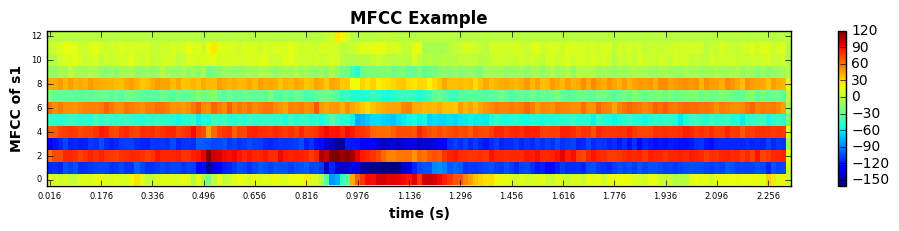

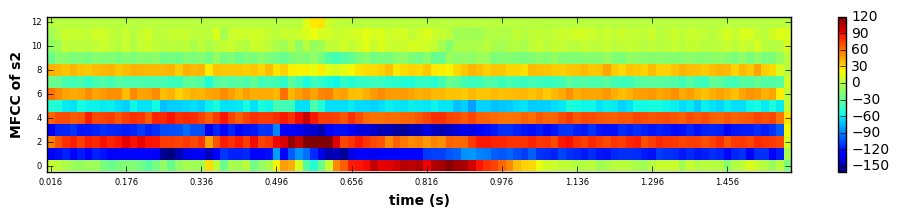

Length of MFCC1 : 145
Length of MFCC2 : 99


In [36]:
#consider 2 series
s1 = dataset[0]
s2 = dataset[1]
MFCC1 = s1.MFCC.T
MFCC2 = s2.MFCC.T
time1 = np.array(xrange(1,MFCC1.shape[1]+1,10))*((s1.window_len-s1.window_overlap)*s1.ts)
time2 = np.array(xrange(1,MFCC2.shape[1]+1,10))*((s2.window_len-s2.window_overlap)*s2.ts)

#plot MFCC of s1
plt.figure(figsize=(12,2))
plt.imshow(MFCC1, interpolation='none', aspect='auto', origin='lower')
plt.xticks(xrange(0,MFCC1.shape[1],10), time1, size=6)
plt.yticks(size=6)
plt.title('MFCC Example', fontweight='bold')
plt.ylabel('MFCC of s1', fontweight='bold')
plt.xlabel('time (s)', fontweight='bold')
plt.set_cmap('jet')
plt.colorbar()
plt.clim(-160, 120);
plt.show()

#plot MFCC of s2
plt.figure(figsize=(12,2))
plt.imshow(MFCC2, interpolation='none', aspect='auto', origin='lower')
plt.xticks(xrange(0,MFCC2.shape[1],10), time2, size=6)
plt.yticks(size=6)
plt.ylabel('MFCC of s2', fontweight='bold')
plt.xlabel('time (s)', fontweight='bold')
plt.set_cmap('jet')
plt.colorbar()
plt.clim(-160, 120);
plt.show()

print 'Length of MFCC1 :', MFCC1.shape[1]
print 'Length of MFCC2 :', MFCC2.shape[1]

In [16]:
def computeOptimalPth(x1, x2):
    N = x1.shape[1]
    M = x2.shape[1]
    #distance matrix
    C = np.zeros((N, M))
    for n in range(N):
        for m in range(M):
            C[n, m] = np.linalg.norm(x1[:,n]-x2[:,m], ord=1)
        
    #cost matrix
    D_ext = np.zeros((N+1, M+1))
    D_ext[0,:] = np.inf
    D_ext[:,0] = np.inf
    D_ext[0,0] = 0

    for n in range(1,N+1):
        for m in range(1,M+1):
            D_ext[n,m] = np.min([D_ext[n-1,m-1], D_ext[n-1,m], D_ext[n,m-1]]) + C[n-1, m-1]
    D = D_ext[1:,1:]

    #compute the optimal path
    p_old = [N-1, M-1]
    path = [p_old]
    while p_old[0]+p_old[1] != 0:
    
        if p_old[0] == 0:
            p_new = [0, p_old[1]-1]
        
        if p_old[1] == 0:
            p_new = [p_old[0]-1, 0]
        
        if p_old[0]!=0 and p_old[1]!=0:
            idx = np.argmin([D[p_old[0]-1, p_old[1]-1], D[p_old[0]-1, p_old[1]], D[p_old[0], p_old[1]-1]])
        
            if idx ==0:
                p_new = [p_old[0]-1, p_old[1]-1]
            
            if idx ==1:
                p_new = [p_old[0]-1, p_old[1]]
            
            if idx ==2:
                p_new = [p_old[0], p_old[1]-1]
        
        p_old = p_new
        path.append(p_old)
    path = np.flip(np.array(path), 0)
    
    #re-synch of the series x1 and x2
    L = path.shape[0]
    x1_new = np.zeros((x1.shape[0], L))
    x2_new = np.zeros((x2.shape[0], L))
    
    for l in range(L):
        x1_new[:, l] = x1[:, path[l, 0]]
        x2_new[:, l] = x2[:, path[l, 1]]
            
    return (path, D, x1_new, x2_new)

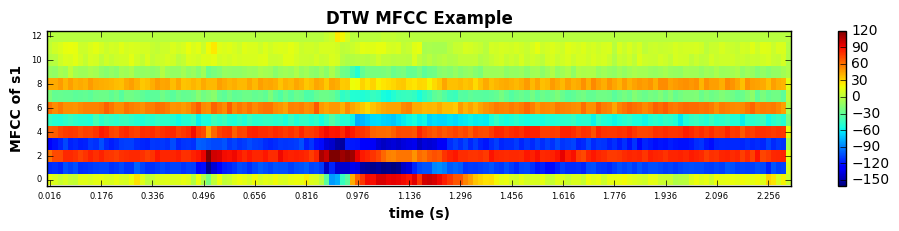

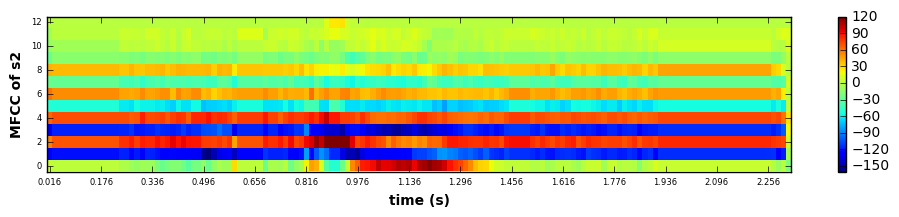

Length of MFCC1 : 145
Length of MFCC2 : 145


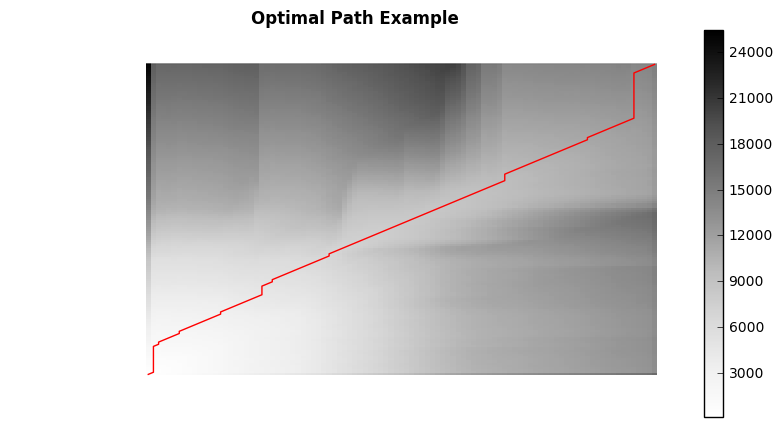

In [17]:
(path, D, MFCC1_new, MFCC2_new) = computeOptimalPth(MFCC1, MFCC2)
time1_new = np.array(xrange(1,MFCC1_new.shape[1]+1,10))*((s1.window_len-s1.window_overlap)*s1.ts)
time2_new = np.array(xrange(1,MFCC2_new.shape[1]+1,10))*((s2.window_len-s2.window_overlap)*s2.ts)

#plot MFCC of x1_new
plt.figure(figsize=(12,2))
plt.imshow(MFCC1_new, interpolation='none', aspect='auto', origin='lower')
plt.xticks(xrange(0,MFCC1_new.shape[1],10), time1_new, size=6)
plt.yticks(size=6)
plt.title('DTW MFCC Example', fontweight='bold')
plt.ylabel('MFCC of s1', fontweight='bold')
plt.xlabel('time (s)', fontweight='bold')
plt.set_cmap('jet')
plt.colorbar()
plt.clim(-160, 120);
plt.show()

#plot MFCC of x2_new
plt.figure(figsize=(12,2))
plt.imshow(MFCC2_new, interpolation='none', aspect='auto', origin='lower')
plt.xticks(xrange(0,MFCC2_new.shape[1],10), time2_new, size=6)
plt.yticks(size=6)
plt.ylabel('MFCC of s2', fontweight='bold')
plt.xlabel('time (s)', fontweight='bold')
plt.set_cmap('jet')
plt.colorbar()
plt.clim(-160, 120);
plt.show()

print 'Length of MFCC1 :', MFCC1_new.shape[1]
print 'Length of MFCC2 :', MFCC2_new.shape[1]

#plot the optimal path
plt.figure(figsize=(10,5))
plt.imshow(D, interpolation='none', aspect='auto', origin='lower')
plt.title('Optimal Path Example', fontweight='bold')
plt.colorbar()
plt.plot(path[:,1], path[:,0], c='r')
plt.set_cmap('Greys')
plt.axis('off')
plt.show()

In [18]:
#compare the two signal
distance = np.sum(np.linalg.norm(MFCC1_new-MFCC2_new, axis=0))
print 'distance from s1 and s2 :', distance

distance from s1 and s2 : 5060.99199079


#### End of the Example

<hr>

# Back to Speech Classification



# Recognizer
### Nearest Neighbor Prediction

<img src="img/codevector3.png" width="900" height="800" />

In [19]:
#split the dataset in train and test set
def split_train_test(dataset, classes, N_tr_per_class=2, N_te_per_class=1, seed=0):
    #shuffle the dataset
    #np.random.seed(seed=seed)
    #np.random.shuffle(dataset)
    
    X_tr = []
    y_tr = np.array([], dtype=int)
    X_te = []
    y_te = np.array([], dtype=int)
    #np.random.seed(seed=seed)
    classes_sh = list(set(classes))
    #np.random.shuffle(classes_sh)
    for cl in classes_sh:
        dataset_i_shuffled = [sample for sample in dataset if sample.n_class == cl]
        np.random.seed(seed=seed)
        np.random.shuffle(dataset_i_shuffled)
        X_tr_i = [sample.MFCC.T for sample in dataset_i_shuffled[:N_tr_per_class]]
        for x in X_tr_i:
            X_tr.append(x)
        y_tr = np.append(y_tr, np.array([sample.n_class for sample in dataset_i_shuffled[:N_tr_per_class]], dtype=int))
        X_te.append(dataset_i_shuffled[N_tr_per_class].MFCC.T)
        y_te = np.append(y_te, np.array([dataset_i_shuffled[N_tr_per_class].n_class], dtype=int))
    
    N_tr = len(X_tr)
    N_te = len(X_te)
    
    return (X_tr, y_tr, X_te, y_te)

In [20]:
def predict(x_0, X_tr, y_tr):
    distances = np.zeros((len(X_tr),))
    for c in range(len(X_tr)):
        (_, _, x1_new, x2_new) = computeOptimalPth(x_0, X_tr[c])
        distances[c] = np.sum(np.linalg.norm(x1_new-x2_new, axis=0))
    y_ = y_tr[np.argmin(distances)]
    
    return y_

In [21]:
#prediciton on the test set
def get_accuracy(X_tr, y_tr, X_te, y_te, dim_tr, n_max_n_tr_per_class, n_avg, N_avg):
    N_te = len(y_te)
    y_pred_te = np.zeros((N_te, ), dtype=int)
    for i in range(N_te):
        clear_output(wait=True)
        print 'n_avg :', n_avg, '/', N_avg
        print 'n_tr_per_class : ', dim_tr, '/', n_max_n_tr_per_class
        print 'Test Prediction...', 1.*i / N_te * 100, '%'
        
        y_pred_te[i] = predict(X_te[i], X_tr, y_tr)
    
    clear_output()
    accuracy_te = 1.*len(np.where(y_pred_te==y_te)[0]) / N_te
    
    return accuracy_te

In [22]:
def get_accuracies(N_avg, n_max_n_tr_per_class, seeds, dataset, classes, load=False):
    accuracies = np.zeros((n_max_n_tr_per_class, N_avg))
    
    if load==True:
        accuracies = sio.loadmat('saved_data/accuracies.mat')['accuracies']
    else:
        for n_avg in range(N_avg):
            for dim_tr in range(1, n_max_n_tr_per_class+1):
                (X_tr, y_tr, X_te, y_te) = split_train_test(dataset, classes, N_tr_per_class=dim_tr, 
                                                            N_te_per_class=1, seed=seeds[n_avg])
                accuracies[dim_tr-1, n_avg] = get_accuracy(X_tr, y_tr, X_te, y_te, dim_tr, 
                                                           n_max_n_tr_per_class, n_avg+1, N_avg)
    return accuracies

In [23]:
N_avg = 20
n_max_n_tr_per_class = 9
seeds = range(N_avg)

#compute the accuracies
accuracies = get_accuracies(N_avg, n_max_n_tr_per_class, seeds, dataset, classes, load=True)

#save the accuracies
#sio.savemat('saved_data/accuracies.mat', {'accuracies': accuracies})

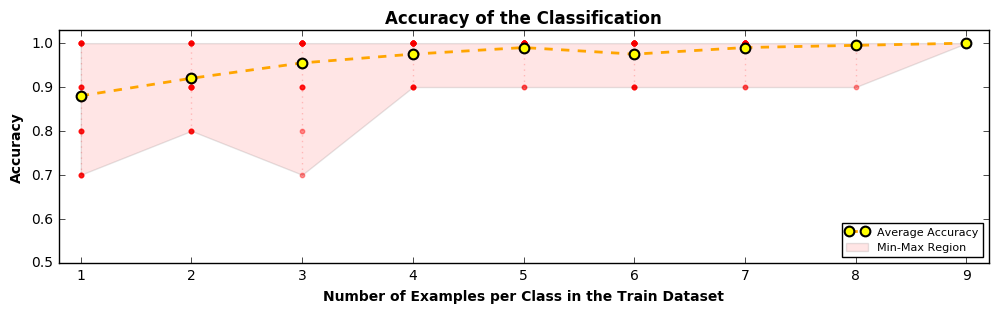

In [24]:
plt.figure(figsize=(12,3))
plt.title('Accuracy of the Classification', fontweight='bold')
for n_avg in range(N_avg):
    plt.scatter(range(1,n_max_n_tr_per_class+1), accuracies[:,n_avg], c='r', alpha=0.4, s=10, edgecolor='r')
for dim_tr in range(1,n_max_n_tr_per_class+1):    
    plt.plot([dim_tr, dim_tr], [np.min(accuracies[dim_tr-1, :]), np.max(accuracies[dim_tr-1, :])], c='r', alpha=0.2, 
            zorder=0, ls=':')
plt.plot(range(1,n_max_n_tr_per_class+1), np.mean(accuracies, axis=1), c='orange', marker='o', markersize=7, 
         markerfacecolor='yellow', markeredgewidth=1.5, ls='--', label='Average Accuracy', linewidth=2)
plt.fill_between(range(1,n_max_n_tr_per_class+1), np.max(accuracies, axis=1), np.min(accuracies, axis=1), 
                where=np.max(accuracies, axis=1) >= np.min(accuracies, axis=1), facecolor='red', interpolate=True,
                alpha=0.1, label='Min-Max Region')
plt.xlabel('Number of Examples per Class in the Train Dataset', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(range(1, n_max_n_tr_per_class+1))
plt.ylim(0.5,1.03)
plt.xlim(0.8,9.2)

plt.legend(loc=4, prop={'size': 8})
plt.show()

<hr>
# Dictionary Approach
Intead of comparing the test audio with all the audio in the training set, I try to build a dictionary from the training set where given a class i want to use only <b>one</b> audio that represent that class to compare the test audio. To do this I have to build a dictionary that contains these codewords.

### Create the Dictionary
To build the dictionary I have to compare the words in the training set that belongs to the same class and choose one to use it as a reference for the class. In this examples words are MFFCs and intuitively I have to choose the best words that get the role of the <b>centroids</b> of the MFFCs in the class. To solve this problem I evaluate the DTW intra-class distance matrix (distance from each words to each word in the same class in the training set) and i choose the words that minimize the sum of the distances squared, formally:
$$MFCC_{centroid} = \underset{MFCC_i}{\operatorname{argmin}} \Bigg\{ \sum_{MFCC_j} DTW\big(MFCC_i, MFCC_j\big)^2 \Bigg\}$$

<br>
### Example

|<center>DTW Matrix Intra-Class Distances</center>|<center>$\textbf{MFCC}_\textbf{centroid}$</center>|
|-|-|
|<img src="img/DTW_matrix_itra_class1.png" width="350" height="1200px" />|<center>$\textbf{MFCC}_\textbf{5}$</center>|


In [25]:
def get_dictionary(dataset, classes, seed=0, N_tr_per_class=2):
    dictionary = {}

    #shuffle the dataset
    dataset_sh = [sample for sample in dataset]
    np.random.seed(seed=seed)
    np.random.shuffle(dataset_sh)


    for class_i in list(set(classes)):
        print '- Class :', class_i
        X_tr_i = [sample.MFCC.T for sample in dataset_sh if sample.n_class==class_i]
        X_tr_i = X_tr_i[:N_tr_per_class]
    
        distances = np.zeros((len(X_tr_i), len(X_tr_i)))
        for i in range(len(X_tr_i)):
            x_i = X_tr_i[i]
            for j in range(i, len(X_tr_i)):
                x_j = X_tr_i[j]
                (_, D, x_i_new, x_j_new) = computeOptimalPth(x_i, x_j)
                distances[i, j] = D[-1,-1]
    
        distances = distances + distances.T
        centroid_idx = np.argmin(np.sum(distances**2, axis=0))
        centroid = X_tr_i[centroid_idx]
        dictionary[class_i] = centroid
    
    return dictionary

In [26]:
def predict_from_dict(x_0, dictionary):
    distances = np.zeros((len(dictionary),))
    for c in range(len(dictionary)):
        (_, _, x1_new, x2_new) = computeOptimalPth(x_0, dictionary[c])
        distances[c] = np.sum(np.linalg.norm(x1_new-x2_new, axis=0))
    y_ = dictionary.keys()[np.argmin(distances)]
    
    return y_

In [27]:
def get_accuracy_dict(X_te, dict):
    y_pred_te = np.zeros((len(X_te,)), dtype=int)
    for i in range(len(X_te)):
        y_pred_te[i] = predict_from_dict(X_te[i], dict)
    accuracy_dict = np.mean(1.*(y_pred_te==y_te))
    
    return accuracy_dict

In [28]:
def get_dictionaries(N_avg, n_max_n_tr_per_class, seeds, dataset, classes, load=False):
    dictionaries = [[[] for _ in range(N_avg)] for _ in range(n_max_n_tr_per_class)]
    
    if load==True:
        dictionaries = sio.loadmat('saved_data/dictionaries.mat')['dictionaries'] 
    else:
        #compute the dictionaries
        for n_avg in range(N_avg):
            for dim_tr in range(1, n_max_n_tr_per_class+1):
                clear_output(wait=True)
                print 'Creation of the dictionaries...'
                print 'n_avg :', n_avg+1, '/', N_avg
                print 'dim_tr :', dim_tr, '/', n_max_n_tr_per_class
        
                dictionaries[dim_tr-1][n_avg] = get_dictionary(dataset, classes, seed=seeds[n_avg],
                                                               N_tr_per_class=dim_tr)
        clear_output()
        
    return dictionaries

In [29]:
def get_accuracies_dict(N_avg, n_max_n_tr_per_class, seeds, dataset, classes, dictionaries, load=False):
    accuracies_dict = np.zeros((n_max_n_tr_per_class, N_avg))
    
    if load==True:
        accuracies_dict = sio.loadmat('saved_data/accuracies_dict.mat')['accuracies_dict']
    else:
        #compute the accuracies after classification with the dictionary approach
        for n_avg in range(N_avg):
            for dim_tr in range(1, n_max_n_tr_per_class+1):
                clear_output(wait=True)
                print 'n_avg :', n_avg+1, '/', N_avg
                print 'dim_tr :', dim_tr, '/', n_max_n_tr_per_class
        
                (_, _, X_te, y_te) = split_train_test(dataset, classes, N_tr_per_class=dim_tr, 
                                                      N_te_per_class=1, seed=seeds[n_avg])
                accuracies_dict[dim_tr-1, n_avg] = get_accuracy_dict(X_te, dictionaries[dim_tr-1][n_avg])
        clear_output()
        
    return accuracies_dict

In [30]:
N_avg = 20
seeds = range(N_avg)
n_max_n_tr_per_class = 9

#compute the dictionaries and accuracies_dict
dictionaries = get_dictionaries(N_avg, n_max_n_tr_per_class, seeds, dataset, classes, load=True)
accuracies_dict = get_accuracies_dict(N_avg, n_max_n_tr_per_class, seeds, dataset, classes, dictionaries, load=True)

#save the dictionaries and accuracies_dict
#sio.savemat('saved_data/dictionaries.mat', {'dictionaries': dictionaries})
#sio.savemat('saved_data/accuracies_dict.mat', {'accuracies_dict': accuracies_dict})

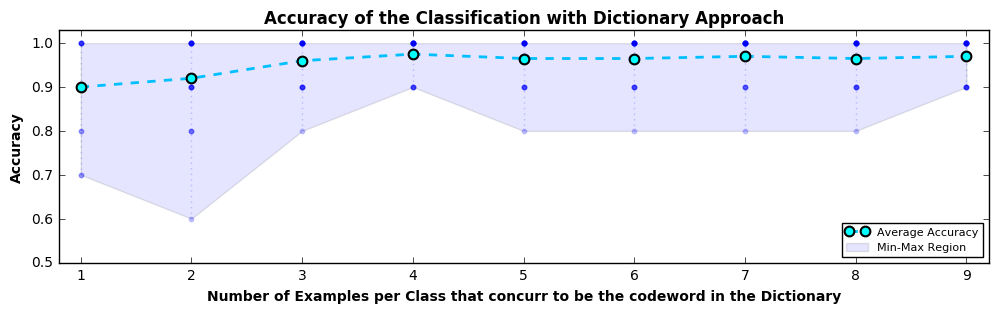

In [31]:
#plot the accuracies
plt.figure(figsize=(12,3))
plt.title('Accuracy of the Classification with Dictionary Approach', fontweight='bold')
for n_avg in range(N_avg):
    plt.scatter(range(1,n_max_n_tr_per_class+1), accuracies_dict[:,n_avg], c='b', alpha=0.2, s=10, edgecolor='b')
for dim_tr in range(1,n_max_n_tr_per_class+1):    
    plt.plot([dim_tr, dim_tr], [np.min(accuracies_dict[dim_tr-1, :]), np.max(accuracies_dict[dim_tr-1, :])], 
             c='b', alpha=0.2, zorder=0, ls=':')
plt.plot(range(1,n_max_n_tr_per_class+1), np.mean(accuracies_dict, axis=1), c='deepskyblue', marker='o', markersize=7, 
         markerfacecolor='aqua', markeredgewidth=1.5, ls='--', label='Average Accuracy', linewidth=2)
plt.fill_between(range(1,n_max_n_tr_per_class+1), np.max(accuracies_dict, axis=1), np.min(accuracies_dict, axis=1), 
                where=np.max(accuracies_dict, axis=1) >= np.min(accuracies_dict, axis=1), facecolor='b', 
                 interpolate=True, alpha=0.1, label='Min-Max Region')
plt.xlabel('Number of Examples per Class that concurr to be the codeword in the Dictionary', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(range(1, n_max_n_tr_per_class+1))
plt.ylim(0.5,1.03)
plt.xlim(0.8,9.2)

plt.legend(loc=4, prop={'size': 8})
plt.show()

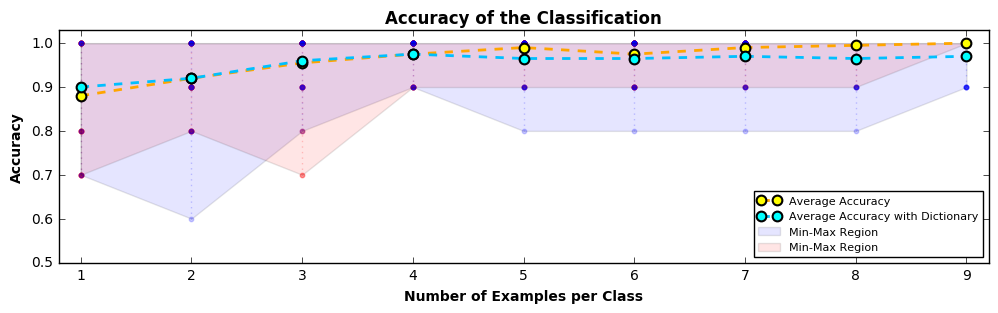

In [32]:
#plot the accuracies
plt.figure(figsize=(12,3))
plt.title('Accuracy of the Classification', fontweight='bold')
for n_avg in range(N_avg):
    plt.scatter(range(1,n_max_n_tr_per_class+1), accuracies[:,n_avg], c='r', alpha=0.4, s=10, edgecolor='r')
for dim_tr in range(1,n_max_n_tr_per_class+1):    
    plt.plot([dim_tr, dim_tr], [np.min(accuracies[dim_tr-1, :]), np.max(accuracies[dim_tr-1, :])], c='r', alpha=0.2, 
            zorder=0, ls=':')
for n_avg in range(N_avg):
    plt.scatter(range(1,n_max_n_tr_per_class+1), accuracies_dict[:,n_avg], c='b', alpha=0.2, s=10, edgecolor='b')
for dim_tr in range(1,n_max_n_tr_per_class+1):    
    plt.plot([dim_tr, dim_tr], [np.min(accuracies_dict[dim_tr-1, :]), np.max(accuracies_dict[dim_tr-1, :])], 
             c='b', alpha=0.2, zorder=0, ls=':')    
plt.plot(range(1,n_max_n_tr_per_class+1), np.mean(accuracies, axis=1), c='orange', marker='o', markersize=7, 
         markerfacecolor='yellow', markeredgewidth=1.5, ls='--', label='Average Accuracy', linewidth=2)
plt.plot(range(1,n_max_n_tr_per_class+1), np.mean(accuracies_dict, axis=1), c='deepskyblue', marker='o', markersize=7, 
         markerfacecolor='aqua', markeredgewidth=1.5, ls='--', label='Average Accuracy with Dictionary', linewidth=2)
plt.fill_between(range(1,n_max_n_tr_per_class+1), np.max(accuracies_dict, axis=1), np.min(accuracies_dict, axis=1), 
                where=np.max(accuracies_dict, axis=1) >= np.min(accuracies_dict, axis=1), facecolor='b', 
                 interpolate=True, alpha=0.1, label='Min-Max Region')
plt.fill_between(range(1,n_max_n_tr_per_class+1), np.max(accuracies, axis=1), np.min(accuracies, axis=1), 
                where=np.max(accuracies, axis=1) >= np.min(accuracies, axis=1), facecolor='red', interpolate=True,
                alpha=0.1, label='Min-Max Region')
plt.xlabel('Number of Examples per Class', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(range(1, n_max_n_tr_per_class+1))
plt.ylim(0.5,1.03)
plt.xlim(0.8,9.2)

plt.legend(loc=4, prop={'size': 8})
plt.show()

## Complexity
* $g_i$ : Class $i$
* $G = |g_i|$ : Number of examples in $g_i$ (I assume that it is constant for all the classes)
* $N_{tot}$ : Number of comparisons with the DTW distance to compute the prediction per class

$$ N_{tot}^{(dict)} =
  \begin{cases}
    {G \choose 2} + 1       &  \text{if } \text{dictionary not pre-computed}\\
    1  & \text{if } \text{dictionary pre-computed}
  \end{cases}
$$

$$N_{tot}^{(train)} = G$$

So at each prediction istant $n$ the algorithm does $N_{tot}(n)$ DTW comparisons per class:
$$N_{tot}^{(dict)}(n) = \left[{G \choose 2} + 1\right]\delta(n) + \big(1-\delta(n)\big) = {G \choose 2}\delta(n)+1$$

$$N_{tot}^{(train)}(n) = G$$

The average complexity per class then is:
$$\mu^{(dict)}(N) = \frac{1}{N} \sum_{n=0}^{N-1} N_{tot}^{(dict)}(n) = \frac{1}{N} \sum_{n=0}^{N-1} \left[{G \choose 2} \delta(n) + 1 \right] = \frac{1}{N} \left[{G \choose 2}  + N \right] \ \xrightarrow{N\to \infty} \  \mu^{(dict)}_{\infty}=1$$

$$\mu^{(train)}(N) = \frac{1}{N} \sum_{n=0}^{N-1} N_{tot}^{(train)}(n)= G \ \xrightarrow{N\to \infty} \    \mu^{(train)}_{\infty} = G$$

In [33]:
N_ = np.arange(1,21)
G = [10]
cmpxt_dict = np.zeros((len(N_),len(G)))
cmpxt_train = np.zeros((len(N_),len(G)))

for i in N_:
    for j in range(len(G)):
        g = G[j]
        cmpxt_dict[i-1, j] = 1./i*g*(g-1)/2 + 1
        cmpxt_train[i-1, j] = g

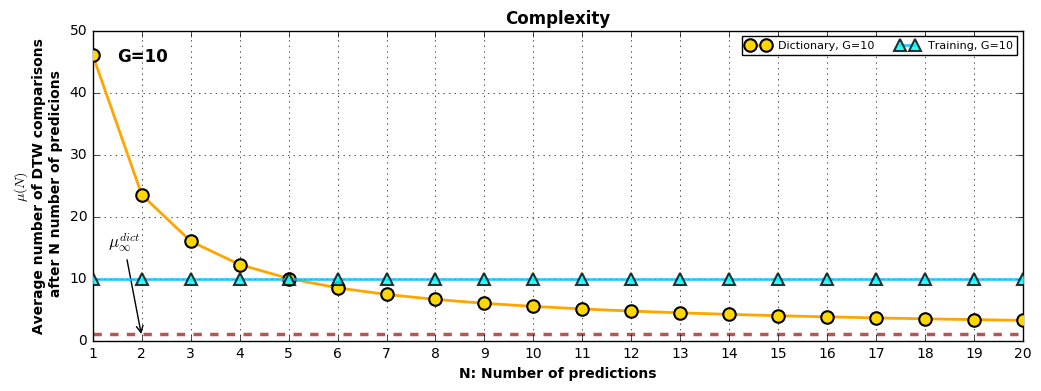

In [34]:
plt.figure(figsize=(12,4))
plt.title('Complexity', fontweight='bold')
lw=2
marker_s = 9

for g in range(len(G)):
    plt.plot(N_, cmpxt_dict[:,g], label='Dictionary, G='+str(G[g]), ls='-', 
            linewidth=lw, c='orange', marker='o', 
            markersize=marker_s, markeredgewidth=1.5, markerfacecolor='gold', zorder=5)
    plt.plot(N_, cmpxt_train[:,g], label='Training, G='+str(G[g]), 
            ls='-', linewidth=lw, c='deepskyblue', marker='^', 
            markersize=marker_s, markeredgewidth=1.5, markerfacecolor='aqua', zorder=10, alpha=0.8)
plt.plot(N_, np.ones((len(N_),)), c='brown', ls='--', lw=2.5, alpha=0.8)
plt.xlim(np.min(N_), np.max(N_))
plt.xticks(N_)
plt.grid('on', zorder=0)
plt.ylabel('$\mu(N)$ \n Average number of DTW comparisons \n after N number of predicions', 
           fontweight='bold')
plt.xlabel('N: Number of predictions', fontweight='bold')
plt.legend(loc=1, prop={'size':8}, ncol=6)
plt.annotate('$\mu_\infty^{dict}$', size=12, xy=(2, 0.6), xytext=(1.3, 15),
           arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.annotate('G=10', size=12, xy=(2, 45), xytext=(1.5, 45), fontweight='bold')
plt.show()

## Resume of the Results

|<center>Model</center>|<center>Accuracy</center>|<center>Complexity $\textbf{(N} \to \infty\textbf{)}$</center>|
|-|-|-|
|<center> DICTIONARY </center>|<center>Reaches 97% of accuracy <br>with 10 tr. pts, but also with <br> less tr. pts works well  (96% <br>of accuracy with 3 tr. pts)</center>|<center>$O(1)$</center>|
|<center>TRAINING</center>|<center>Reaches 100% of accuracy <br> with 10 tr. pts, but also with <br> less tr. pts works well (95% <br> of accuracy with 3 tr. pts)</center>|<center>$O(G)$</center>|

## Future Work
* Multi-person Speech Regognizer
* Improve the model with a Language Model
* Try more powerfull models like HMM or RNN

### Acknowledgements
* <b>[1]</b> Meinard Müller. 2007. <i>Information Retrieval for Music and Motion.</i> Springer-Verlag New York, Inc., Secaucus, NJ, USA.


* <b>[2]</b> Lindasalwa Muda, Mumtaj Begam and I. Elamvazuthi. <i>Voice Recognition Algorithms using Mel Frequency Cepstral Coefficient (MFCC) and Dynamic Time Warping (DTW) Techniques.</i> Journal of Computing, Volume 2, Issue 3, March 2010.


* <b>[3]</b> Mohan. B, Jagan & Babu.N, Ramesh. (2014). <i>Speech recognition using MFCC and DTW.</i> . 10.1109/ICAEE.2014.6838564. 


* <b>[4]</b> G. De Poli, L. Mion, N. Orio, A. Roda. <i> Chapter 6 - From audio to content</i>.